> A basic introduction to vector distance zonal stats 

[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/tutorial.distance_zonal_stats.ipynb)

In [ ]:
#| include: false
# all_slow

In [ ]:
#| include: false
#| no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [ ]:
#| include: false
#| no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Basic Usage

Generate area zonal stats for a GeoDataframe containing areas of interest with a vector data source with the nearest distance.

:::{.callout-note}

The data geometries can be points, lines or areas with distance computed from the closest points on both the aoi and the data source. Both the aoi and the data source must be projected using a "planar" CRS.

:::


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import geowrangler.distance_zonal_stats as dzs

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
# download sample geojson files from repo
![ ! -e ../data/simple_planar_aoi.geojson ] && curl -s -o ../data/simple_planar_aoi.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/simple_planar_aoi.geojson
![ ! -e ../data/simple_planar_data.geojson ] && curl -s -o ../data/simple_planar_data.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/simple_planar_data.geojson
![ ! -e ../data/region3_admin_grids.geojson ] && curl -s -o ../data/region3_admin_grids.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin_grids.geojson
![ ! -e ../data/region34ncr_osm_pois.geojson ] && curl -s -o ../data/region34ncr_osm_pois.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region34ncr_osm_pois.geojson

### Simple Grid AOIs and Nearby POI/Area Data Example

In [ ]:
#| include: false
def make_point_df(
    xsize,
    ysize,
    has_internet=True,
    has_population=True,
    size=1,
    offset_x=0.25,
    offset_y=0.0,
    pop_x_factor=100,
    pop_y_factor=0,
    internet_base_speed=20.0,
    internet_x_exp=2.0,
    internet_y_factor=100,
    crs="EPSG:3857",
):
    d = dict(
        geometry=[
            Point(x + offset_x, y + offset_y)
            for x in range(xsize)
            for y in range(ysize)
        ]
    )
    if has_population:
        d["population"] = [
            pop_x_factor * (x + 1) + y * (pop_x_factor * ysize + pop_y_factor)
            for x in range(xsize)
            for y in range(ysize)
        ]
    if has_internet:
        d["internet_speed"] = [
            internet_base_speed / (internet_x_exp**x) + internet_y_factor * y
            for x in range(xsize)
            for y in range(ysize)
        ]
    return gpd.GeoDataFrame(d, crs=crs)

In [ ]:
simple_aoi = gpd.read_file("../data/simple_planar_aoi.geojson")
simple_data = gpd.read_file("../data/simple_planar_data.geojson")

In [ ]:
simple_point_data = make_point_df(3, 5, offset_x=0.5, offset_y=3.0)

Given an aoi (`simple_aoi`), a sample area data source (`simple_data`), and a sample point data source

In [ ]:
simple_aoi

,geometry
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))"
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))"
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))"


In [ ]:
simple_data

,population,internet_speed,geometry
0,100,20.0,"POLYGON ((0.25 0, 0.25 1, 1.25 1, 1.25 0, 0.25..."
1,200,10.0,"POLYGON ((1.25 0, 1.25 1, 2.25 1, 2.25 0, 1.25..."
2,300,5.0,"POLYGON ((2.25 0, 2.25 1, 3.25 1, 3.25 0, 2.25..."


In [ ]:
simple_point_data

,geometry,population,internet_speed
0,POINT (0.5 3),100,20.0
1,POINT (0.5 4),600,120.0
2,POINT (0.5 5),1100,220.0
3,POINT (0.5 6),1600,320.0
4,POINT (0.5 7),2100,420.0
5,POINT (1.5 3),200,10.0
6,POINT (1.5 4),700,110.0
7,POINT (1.5 5),1200,210.0
8,POINT (1.5 6),1700,310.0
9,POINT (1.5 7),2200,410.0


In order correctly compute distances from the aoi to the data sources, we need to make sure that the aoi, data and point data geodataframes are using a `planar` CRS (i.e. `gdf.crs.is_geographic == False`)

In [ ]:
simple_aoi.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
simple_data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
simple_point_data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We have an aoi (`simple_aoi`) and geodataframe containing sample data (`simple_data`) that overlaps the aoi.
We also have simple point data which do not intersect with our AOIs.

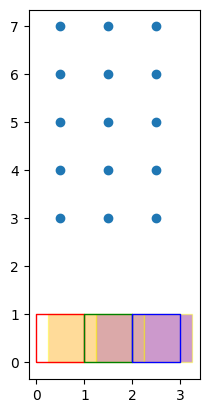

In [ ]:
ax = plt.axes()
ax = simple_data.plot(
    ax=ax, color=["orange", "brown", "purple"], edgecolor="yellow", alpha=0.4
)
ax = simple_aoi.plot(ax=ax, facecolor="none", edgecolor=["r", "g", "b"])
ax = simple_point_data.plot(ax=ax)

The red,green,blue outlines are the 3 regions of interest (aoi) while the orange,brown, purple areas are the data areas.The blue dots are data which do not intersect our AOIs. 

In [ ]:
%%time
results = dzs.create_distance_zonal_stats(
    simple_aoi,
    simple_point_data,
    max_distance=7,
    aggregations=[
        dict(func="count"),
        dict(func="sum", column="population"),
        dict(func="mean", column="internet_speed"),
    ],
)

CPU times: user 6.01 ms, sys: 1.4 ms, total: 7.41 ms
Wall time: 9.12 ms


The zonal stats computed for the point data only includes those points nearest to each aoi. The data geometries within nearest distance (within `7.0` m) are the only ones considered.

:::{.callout-note}

Setting the `max_distance` to `None` or a large value can cause a possible slowdown for large datasets. See this [Geopandas reference](https://geopandas.org/en/latest/docs/user_guide/mergingdata.html#nearest-joins) for more details.

:::

In [ ]:
results

,geometry,index_count,population_sum,internet_speed_mean,nearest
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",1,100,20.0,2.0
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",1,200,10.0,2.0
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",1,300,5.0,2.0


Data areas and geometries which overlap the aoi areas have a distance of `0.0`  and are always the nearest geometries.

In [ ]:
%%time
results2 = dzs.create_distance_zonal_stats(
    simple_aoi,
    simple_data,
    max_distance=1,
    aggregations=[
        dict(func="count"),
        dict(func="sum", column="population"),
        dict(func="mean", column="internet_speed"),
    ],
)

CPU times: user 5.63 ms, sys: 576 µs, total: 6.2 ms
Wall time: 5.9 ms


In [ ]:
results2

,geometry,index_count,population_sum,internet_speed_mean,nearest
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",1,100,20.0,0.0
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",2,300,15.0,0.0
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",2,500,7.5,0.0


### Custom Grids and POIs Example

In [ ]:
%%time
region3_admin_grids = gpd.read_file("../data/region3_admin_grids.geojson")

CPU times: user 15.2 ms, sys: 626 µs, total: 15.8 ms
Wall time: 16.4 ms


In [ ]:
%%time
region34ncr_osm_pois = gpd.read_file("../data/region34ncr_osm_pois.geojson")

CPU times: user 29.4 ms, sys: 1.06 ms, total: 30.4 ms
Wall time: 30.8 ms


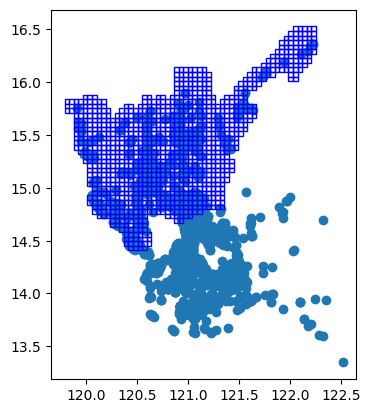

In [ ]:
ax = plt.axes()
ax = region34ncr_osm_pois.plot(ax=ax)
ax = region3_admin_grids.plot(ax=ax, facecolor="none", edgecolor="blue")

In [ ]:
region3_admin_grids = region3_admin_grids.to_crs("EPSG:3857")  # convert to planar
region34ncr_osm_pois = region34ncr_osm_pois.to_crs("EPSG:3857")

In [ ]:
region34ncr_osm_pois

,osm_id,code,fclass,name,BARANGAY_CODE,geometry
0,311568428,2701,tourist_info,Manila American Cemetery and Memorial Visitor ...,137602022,POINT (13475059.129 1636701.151)
1,672565496,2701,tourist_info,ecopark paging and first aid station,137404141,POINT (13477983.748 1656000.058)
2,672565498,2701,tourist_info,Ecopark ticket counter,137404141,POINT (13477813.318 1656135.868)
3,1585389544,2701,tourist_info,Area Formerly Occupied by Fort Bonifacio Museum,137602021,POINT (13476156.594 1637474.593)
4,1834855424,2701,tourist_info,Lotto Booth,137601020,POINT (13468786.053 1622805.175)
...,...,...,...,...,...,...
2829,1282790636,2723,monument,Rizal Monument,030808004,POINT (13387876.843 1652143.344)
2830,1430752967,2723,monument,Rizal Monument,034903092,POINT (13464327.852 1743609.163)
2831,2280492117,2723,monument,Rizal Monument,031421037,POINT (13467118.142 1705384.453)
2832,4898774223,2723,monument,Rizal Monument,035414009,POINT (13434387.128 1685457.796)


In [ ]:
%%time
results3 = dzs.create_distance_zonal_stats(
    region3_admin_grids,
    region34ncr_osm_pois,
    max_distance=10_000,  # within 10km
    aggregations=[dict(func="count", output="pois_count", fillna=[True])],
)

CPU times: user 16.5 ms, sys: 1.13 ms, total: 17.7 ms
Wall time: 17.7 ms


In [ ]:
len(results3[results3.pois_count == 0.0])

165

In [ ]:
results3

,x,y,geometry,pois_count,nearest
0,0,30,"POLYGON ((13334497.956 1771012.807, 13339497.9...",1.0,8849.591855
1,0,31,"POLYGON ((13334497.956 1776012.807, 13339497.9...",1.0,8844.448848
2,0,32,"POLYGON ((13334497.956 1781012.807, 13339497.9...",0.0,NaN
3,1,30,"POLYGON ((13339497.956 1771012.807, 13344497.9...",1.0,3856.266007
4,1,32,"POLYGON ((13339497.956 1781012.807, 13344497.9...",1.0,6070.762498
...,...,...,...,...,...
1069,54,44,"POLYGON ((13604497.956 1841012.807, 13609497.9...",1.0,674.134053
1070,54,45,"POLYGON ((13604497.956 1846012.807, 13609497.9...",2.0,0.000000
1071,54,46,"POLYGON ((13604497.956 1851012.807, 13609497.9...",1.0,4237.158313
1072,54,47,"POLYGON ((13604497.956 1856012.807, 13609497.9...",1.0,9237.158313
